In [1]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib
!git clone https://github.com/facebookresearch/segment-anything.git


  Preparing metadata (setup.py) ... done
Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 304 (delta 2), reused 1 (delta 1), pack-reused 299 (from 2)
Receiving objects: 100% (304/304), 18.31 MiB | 34.66 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor


In [4]:
import os

# Create  directory 
os.makedirs("models", exist_ok=True)

# Download SAM ViT-B model
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O models/sam_vit_b_01ec64.pth


In [5]:
!nvidia-smi

Mon Sep  8 14:31:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


In [7]:
# Step 3: Load and prepare image
image = cv2.imread("/kaggle/input/image-cat/cat.4041.jpg")  # replace with image file name
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

input_point = np.array([[100,100], [150,150], [250,350]])
input_label = np.array([1, 1, 1])  # '1' means all these are inside the objectforeground

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


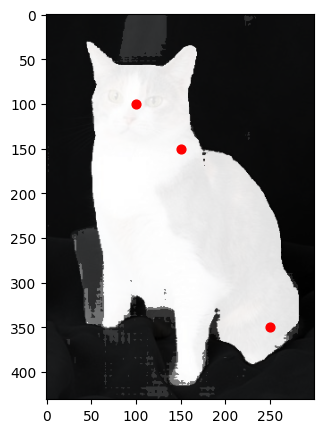

In [8]:
# Step 4: Visualize
def show_mask(mask, ax, color):
    ax.imshow(mask, cmap='gray', alpha=0.5)

fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(image)
for i, mask in enumerate(masks):
    show_mask(mask, ax, color=(0, 1, 0))
ax.scatter(input_point[:, 0], input_point[:, 1], color='red', s=40)
plt.axis('on')
plt.show()


In [9]:
print(f"Image shape: {image.shape}")
print(f"Number of masks: {len(masks)}")
print(f"Input point: {input_point}")


Image shape: (431, 300, 3)
Number of masks: 3
Input point: [[100 100]
 [150 150]
 [250 350]]


In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(f"Found {len(masks)} objects!")


Found 26 objects!


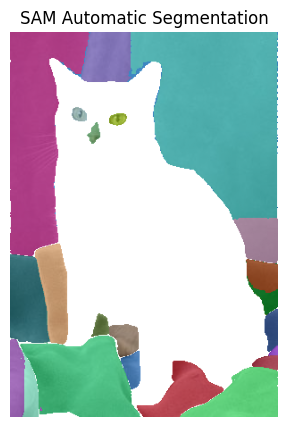

In [11]:
def show_anns(masks):
    if len(masks) == 0:
        print("No masks found!")
        return

    sorted_anns = sorted(masks, key=lambda x: x['area'], reverse=True)
    img = np.ones((image.shape[0], image.shape[1], 4))
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.6]])
        img[m] = color_mask

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.imshow(img)
    plt.axis('off')
    plt.title("SAM Automatic Segmentation")
    plt.show()

show_anns(masks)


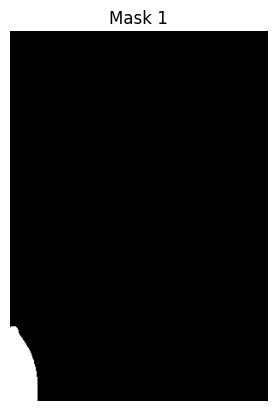

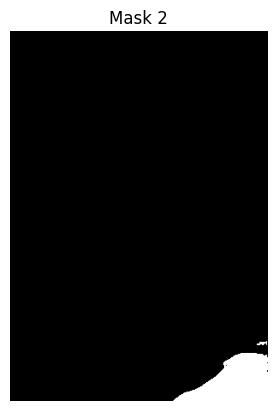

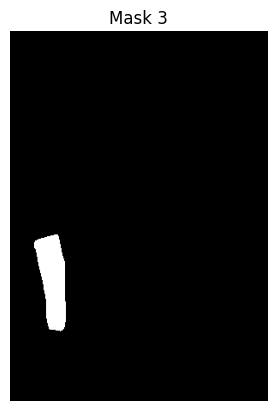

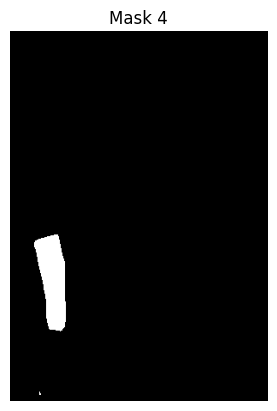

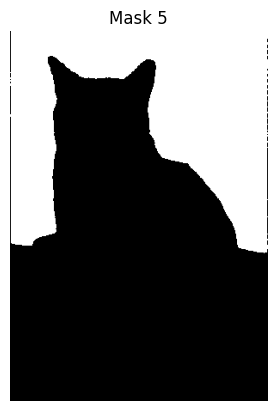

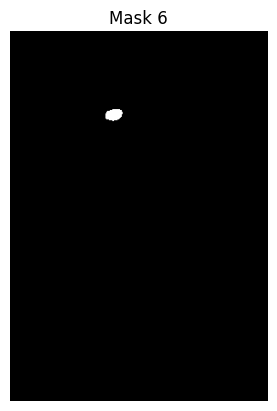

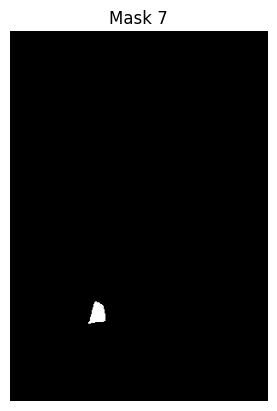

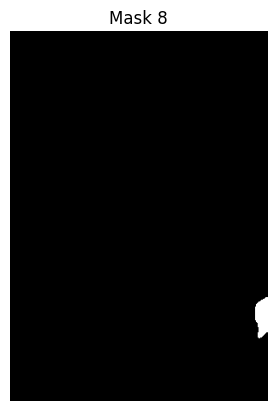

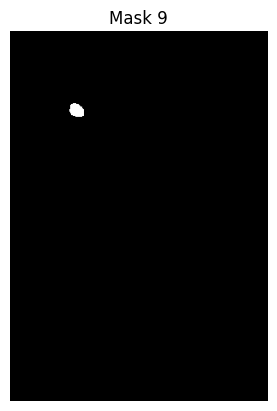

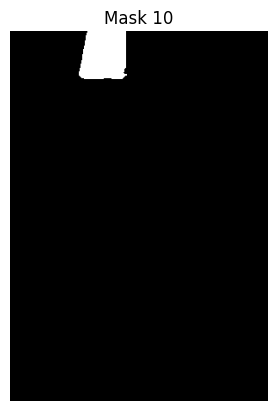

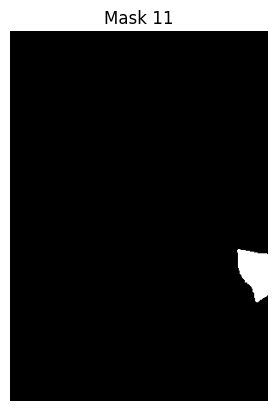

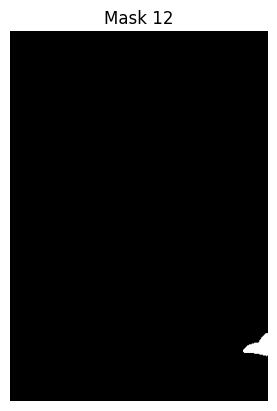

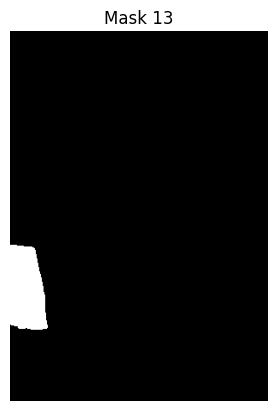

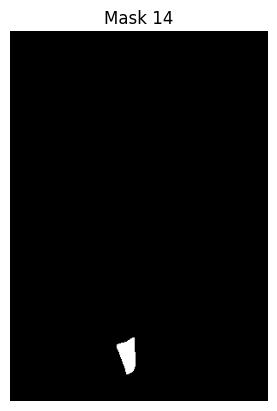

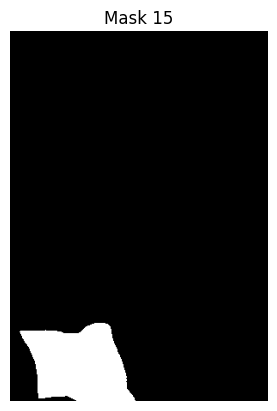

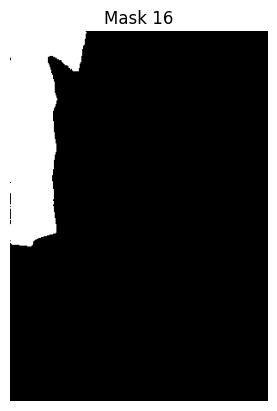

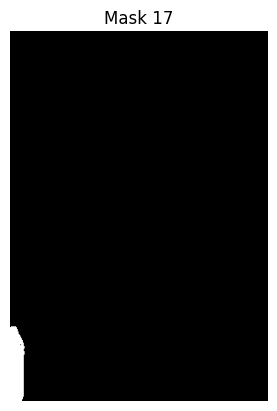

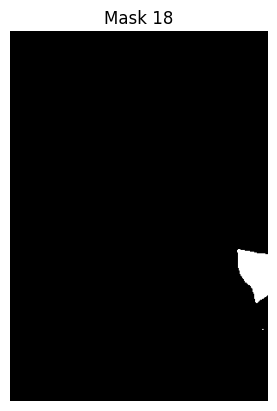

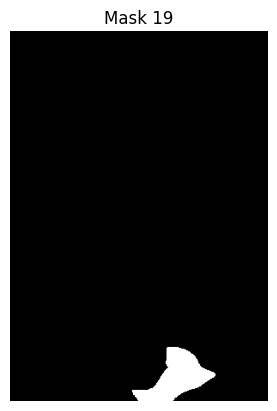

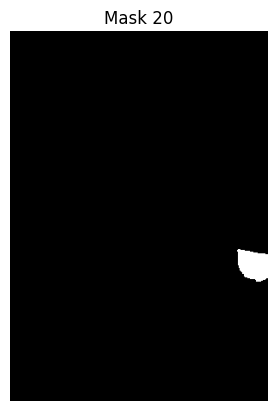

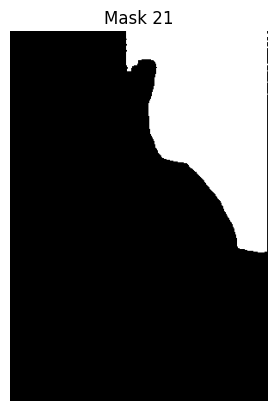

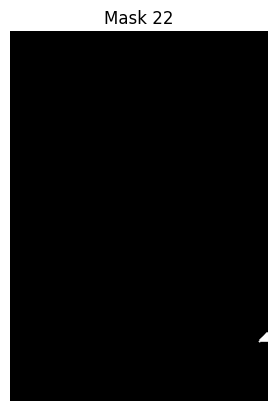

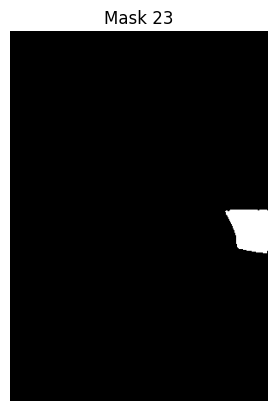

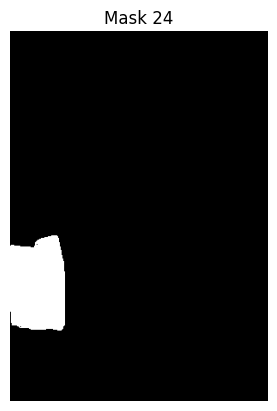

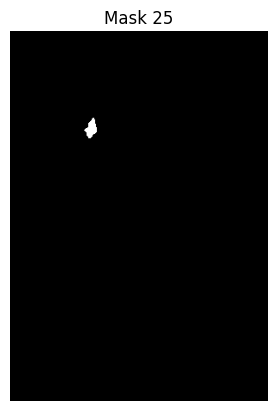

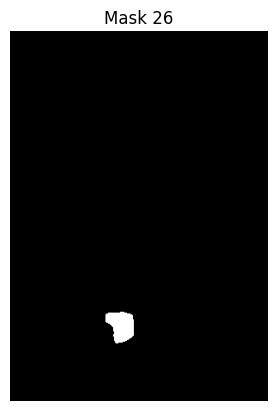

In [12]:
# Show each segmentation 
for i, mask in enumerate(masks):
    plt.figure()
    plt.imshow(mask["segmentation"], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')
    plt.show()
